<a href="https://colab.research.google.com/github/iamhlasoe/btc-price-prediction/blob/main/notebooks/FirstModel_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MSc. DA Project: Bitcoin price prediction using Sentiment analysis and Deep Learning

##### First Modle: RNN LSTM with Tweet Sentiments

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-7vzlig7w
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-7vzlig7w
  Resolved https://github.com/paulgavrikov/visualkeras to commit 8d42f3a9128373eac7b4d38c23a17edc9357e3c9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 10.6 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.1.4-py3-none-any.whl size=17145 sha256=4a3b8eff7b5f59e26e1c334494c16170d468c63a124cab896f88dc2a68b8c5a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-084ttus3/wheels/be/f7/2b/90cdf278d2022271c504be10866520c5d94d4a82c919b77302
Successfully built visualkeras


In [ ]:
# @title Importing Libraries
import datetime
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import Model
from keras.models import Sequential, save_model, load_model, Model
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
from keras.layers import BatchNormalization, Input, Flatten

#for model visualizatin
import visualkeras as vk
#import yfinance as yf

In [ ]:
# @title Load csv file into DataFrame
df = pd.read_csv('Data/Cleaned_Dataset.csv')

In [ ]:
# @title Changing date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Modeling

In [ ]:
# @title Feature Selection

df_selected = df[['Sent_Positives', 'Sent_Negatives', 'Close']]
df_selected.head()

,Sent_Positives,Sent_Negatives,Close
0,0.417882,-0.516620,2825.92
1,0.415385,-0.423402,2853.38
2,0.428661,-0.440938,2841.60
3,0.396034,-0.441173,2862.93
4,0.417159,-0.414978,2874.99


In [ ]:
# @title Feature Normalization

features_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))

scaled_features = features_scaler.fit_transform(df[['Sent_Positives', 'Sent_Negatives']])
scaled_target = target_scaler.fit_transform(df[['Close']])

concatenated_features = np.concatenate((scaled_features, scaled_target), axis=1)

df_training = pd.DataFrame(concatenated_features, columns=['Sent_Positives', 'Sent_Negatives', 'Close'])
df_training.head()

,Sent_Positives,Sent_Negatives,Close
0,0.624127,0.358005,0.008971
1,0.620398,0.539748,0.010576
2,0.640226,0.505558,0.009887
3,0.591497,0.505100,0.011134
4,0.623048,0.556171,0.011839


In [ ]:
#features_scaler = MinMaxScaler(feature_range=(0,1))
#target_scaler = MinMaxScaler(feature_range=(0,1))

#scaled_features = features_scaler.fit_transform(df[['Sent_Positives','Sent_Negatives']])
#scaled_target = target_scaler.fit_transform(df[['Close']])

#concatenated_features = np.concatenate((scaled_features, scaled_target), axis=1)

#df_features_scaled = pd.DataFrame(scaled_features, columns=['Sent_Positives','Sent_Negatives'])
#df_target_scaled = pd.DataFrame(scaled_target, columns=['Close'])

#df_training = pd.concat([df_features_scaled,df_target_scaled], axis=1)
#df_training

In [ ]:
#unscaled_train = target_scaler.inverse_transform(scaled_target)
#pd.DataFrame(unscaled_train, columns = ['Close']).head()

In [ ]:
# @title Creating Sequences for 2 days (48 datapoints)

def prepare_dataset_model(data, n_past=48, n_future=1):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])
        y.append(data[i + n_future - 1:i + n_future, -1])  # The 'Close' price is the target
    return np.array(X), np.array(y)

# Split the data into training and testing sets
train_size = int(len(concatenated_features) * 0.8)
test_size = len(concatenated_features) - train_size
train_data, test_data = concatenated_features[:train_size], concatenated_features[train_size:]

n_past = 48
n_future = 1
X, y = prepare_dataset_model(concatenated_features, n_past, n_future)
print('X shape == {} | y shape == {}'.format(X.shape, y.shape))
# Create training sequences
X_train, y_train = prepare_dataset_model(train_data, n_past, n_future)
# Create testing sequences
X_test, y_test = prepare_dataset_model(test_data, n_past, n_future)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape == (12310, 48, 3) | y shape == (12310, 1)
X_train shape: (9838, 48, 3)
y_train shape: (9838, 1)
X_test shape: (2424, 48, 3)
y_test shape: (2424, 1)


In [ ]:
# @title Building the RNN LSTM Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 48, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 48, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,251 (200.20 KB)

 Trainable params: 51,251 (200.20 KB)

 Non-trainable params: 0 (0.00 B)

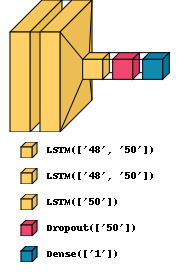

In [ ]:
vk.layered_view(model, legend=True, show_dimension=True, scale_xy=2, scale_z=0, max_z=1000)

In [ ]:
# @title Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=25, validation_split=0.2)

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 49s 131ms/step - loss: 0.0087 - val_loss: 6.7382e-05
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - loss: 0.0014 - val_loss: 1.8848e-04
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - loss: 0.0011 - val_loss: 8.9159e-05
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - loss: 9.1374e-04 - val_loss: 6.4430e-04
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - loss: 0.0010 - val_loss: 1.1797e-04
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - loss: 7.8004e-04 - val_loss: 5.8749e-05
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - loss: 7.1126e-04 - val_loss: 6.4842e-05
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 6.8208e-04 - val_loss: 1.3491e-04
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - loss: 5.8360e-04 - val_loss: 6.8680e-05
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - loss: 5.9629e-04 - val_loss: 6.2635e-05
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step

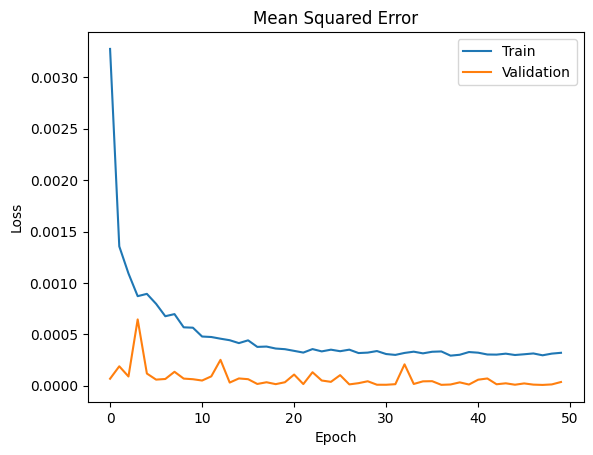

In [ ]:
# @title Visualizing the training LSTM model

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# @title Saving the trained modle for future
model.save('Models/FirstModel_Sentiment.h5')

In [ ]:
# Load the saved model (if needed later)
trained_model = load_model('Models/FirstModel_Sentiment.h5')

In [ ]:
# @title Evaluating Model Performance with test set

test_loss = trained_model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.5519e-05
Test Loss:  9.802474232856184e-05


In [ ]:
# @title Performance Matrices of Model Test
y_pred = trained_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Mean Absolute Error:  0.00934350070441714
Root Mean Square Error:  0.009900743760416029


In [ ]:
# @title Actual vs Model prediction

prediction = trained_model.predict(X_test)
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = prediction.reshape(-1, 1)

y_test_inverse = target_scaler.inverse_transform(y_test_reshaped)
y_pred_inverse = target_scaler.inverse_transform(y_pred_reshaped)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [ ]:
# Plot the actual vs predicted values
#test_dates = df['Date'].iloc[-len(y_test):]
#plt.figure(figsize=(8, 4), dpi=300)
#plt.plot(test_dates,y_test_inverse, label="Actual Price", color='green', lw=1)
#plt.plot(test_dates,y_pred_inverse, label="Predicted Price", color='Red', lw=1)

#plt.title('Multi-LSTM-Sentiment Model - Prediction')
#plt.xlabel('Date')
#plt.ylabel('Price')
#plt.grid(False)
#plt.legend(loc='best')
#plt.xticks(rotation=90)
#plt.show()

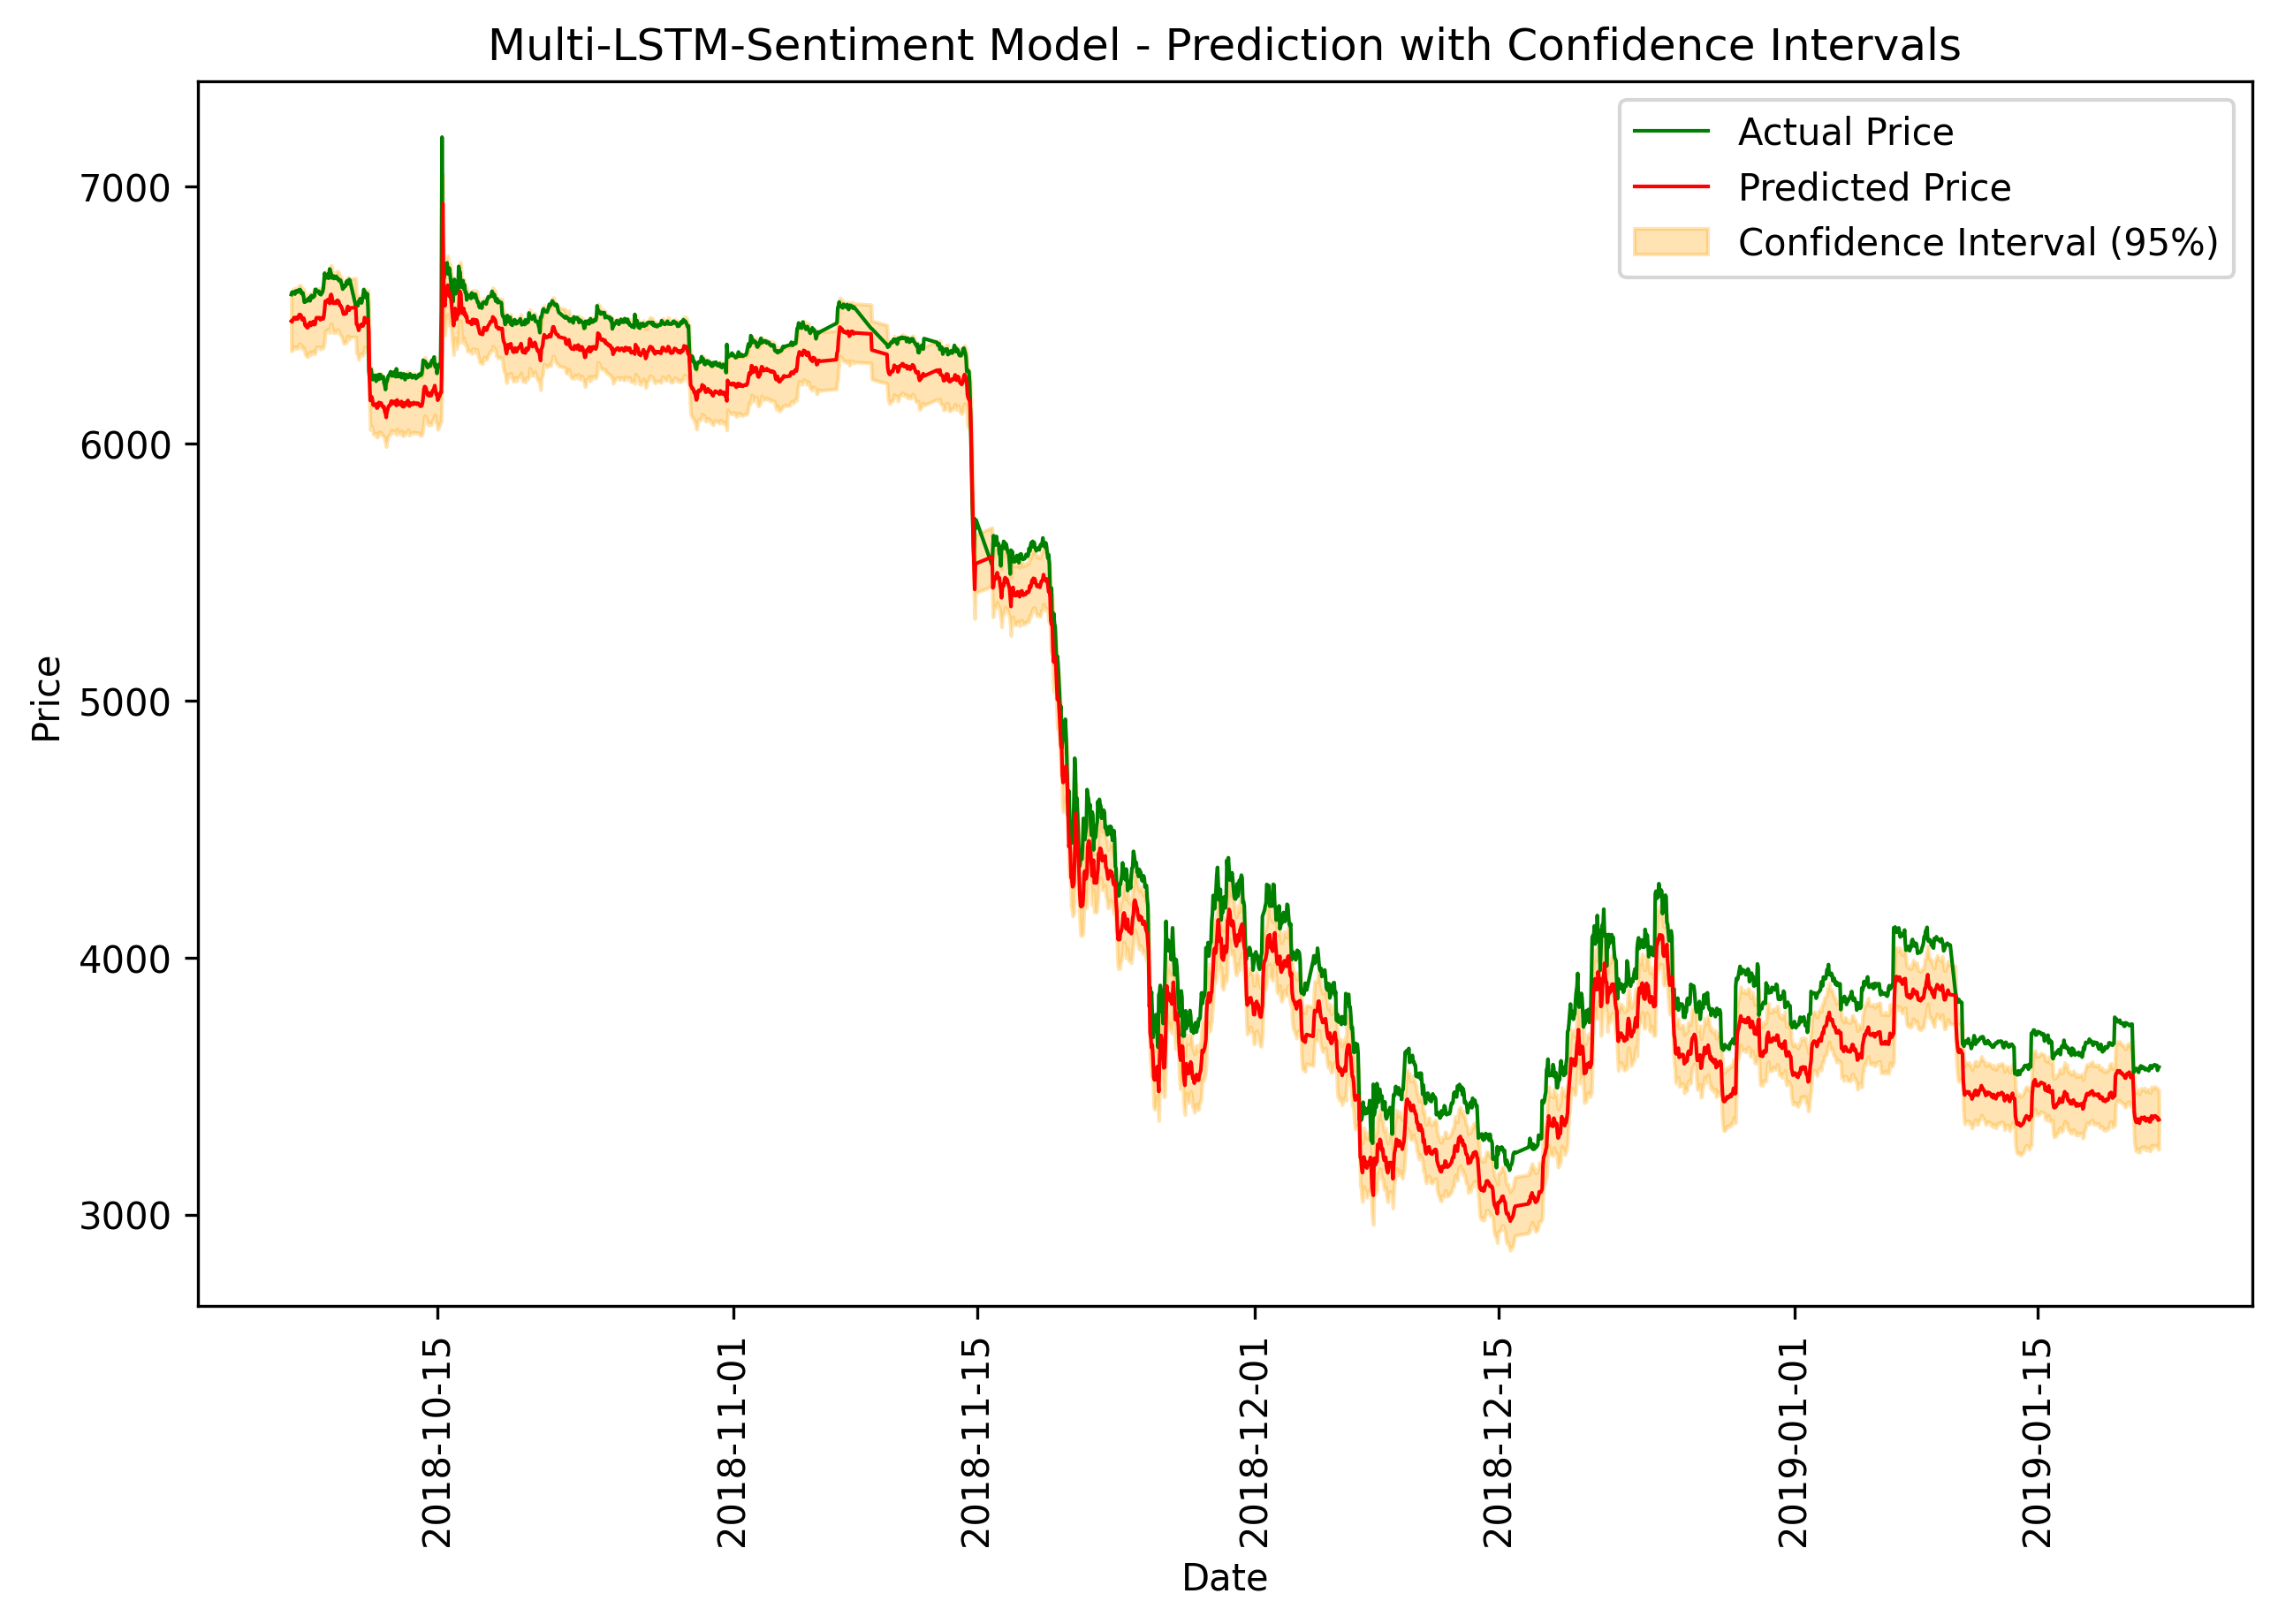

In [ ]:
# @title Calculate confidence intervals
residuals = (y_test_inverse - y_pred_inverse).flatten()
std_residuals = np.std(residuals)

# Define the confidence intervals (95% confidence)
confidence_level = 1.96  # For 95% confidence interval (z-score)
upper_bound = (y_pred_inverse + confidence_level * std_residuals).flatten()
lower_bound = (y_pred_inverse - confidence_level * std_residuals).flatten()

# Plot the actual vs predicted values with confidence intervals
test_dates = df['Date'].iloc[-len(y_test):]
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_dates, y_test_inverse, label="Actual Price", color='green', lw=1)
plt.plot(test_dates, y_pred_inverse, label="Predicted Price", color='red', lw=1)
plt.fill_between(
    test_dates,
    lower_bound,
    upper_bound,
    color='orange',
    alpha=0.3,
    label="Confidence Interval (95%)"
)

plt.title('Multi-LSTM-Sentiment Model - Prediction with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()


### Model Tunning

In [ ]:
# @title Building the Tune RNN LSTM Model

tune_model = Sequential()
tune_model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
tune_model.add(LSTM(units=30, return_sequences=True))
tune_model.add(LSTM(units=30, return_sequences=False))
tune_model.add(Dropout(0.3))
tune_model.add(Dense(y_train.shape[1]))
tune_model.compile(optimizer='adam', loss='mean_squared_error')
tune_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 48, 30)              │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 48, 30)              │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,751 (73.25 KB)

 Trainable params: 18,751 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


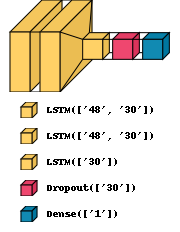

In [ ]:
vk.layered_view(tune_model, legend=True, show_dimension=True, scale_xy=2, scale_z=0, max_z=1000)

In [ ]:
# @title Training the model
tune_history = tune_model.fit(X_train, y_train, epochs=40, batch_size=30, validation_split=0.2)

Epoch 1/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - loss: 0.0127 - val_loss: 1.8511e-04
Epoch 2/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - loss: 0.0024 - val_loss: 2.3065e-04
Epoch 3/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - loss: 0.0019 - val_loss: 4.5675e-04
Epoch 4/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 0.0016 - val_loss: 8.1689e-05
Epoch 5/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - loss: 0.0013 - val_loss: 1.5768e-04
Epoch 6/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 0.0012 - val_loss: 1.0432e-04
Epoch 7/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.0011 - val_loss: 5.9285e-04
Epoch 8/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 0.0011 - val_loss: 6.7895e-05
Epoch 9/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 9.3326e-04 - val_loss: 2.2794e-04
Epoch 10/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 9.6996e-04 - val_loss: 5.3454e-05
Epoch 11/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 8.9826e-

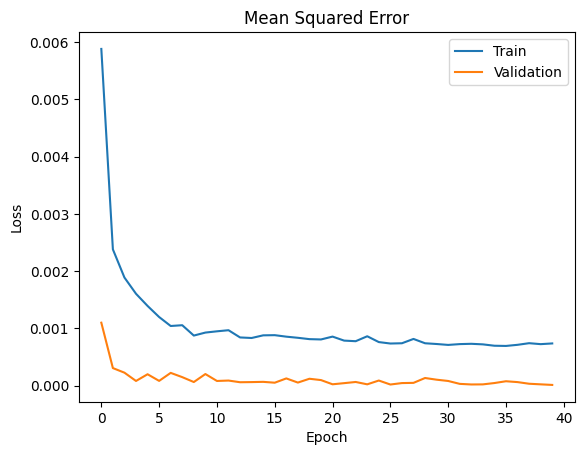

In [ ]:
# @title Visualizing the training LSTM model

plt.plot(tune_history.history['loss'])
plt.plot(tune_history.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# @title Saving tunned modle for future
tune_model.save('Models/TuneFirstModel_Sentiment.keras')
#keras.saving.save_model(tune_model, 'Models/TuneFirstModel_Sentiment.keras')

In [ ]:
# Load the saved model (if needed later)
#load_tune_model = load_model('Models/FirstModel_Sentiment.h5')
load_tune_model = keras.models.load_model('Models/TuneFirstModel_Sentiment.keras')

In [ ]:
# @title Evaluating Model Performance with test set

tune_test_loss = load_tune_model.evaluate(X_test, y_test)
print("Tune Model Test Loss: ", tune_test_loss)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.8226e-06
Tune Model Test Loss:  9.291126843891107e-06


In [ ]:
# @title Performance Matrices of Model Test
tune_pred = load_tune_model.predict(X_test)
tune_mae = mean_absolute_error(y_test, tune_pred)
#tune_rmse = mean_squared_error(y_test, tune_pred, squared=False)

tune_mse = mean_squared_error(y_test, tune_pred)
tune_rmse = tune_mse ** 0.5

print("Tune Model Mean Absolute Error: ", tune_mae)
print("Tune Model Root Mean Square Error: ", tune_rmse)

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Tune Model Mean Absolute Error:  0.001963499046965201
Tune Model Root Mean Square Error:  0.0030481348776532674


In [ ]:
# @title Actual vs Model prediction

tune_prediction = load_tune_model.predict(X_test)
tune_y_test_reshaped = y_test.reshape(-1, 1)
tune_y_pred_reshaped = tune_prediction.reshape(-1, 1)

tune_y_test_inverse = target_scaler.inverse_transform(tune_y_test_reshaped)
tune_y_pred_inverse = target_scaler.inverse_transform(tune_y_pred_reshaped)

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


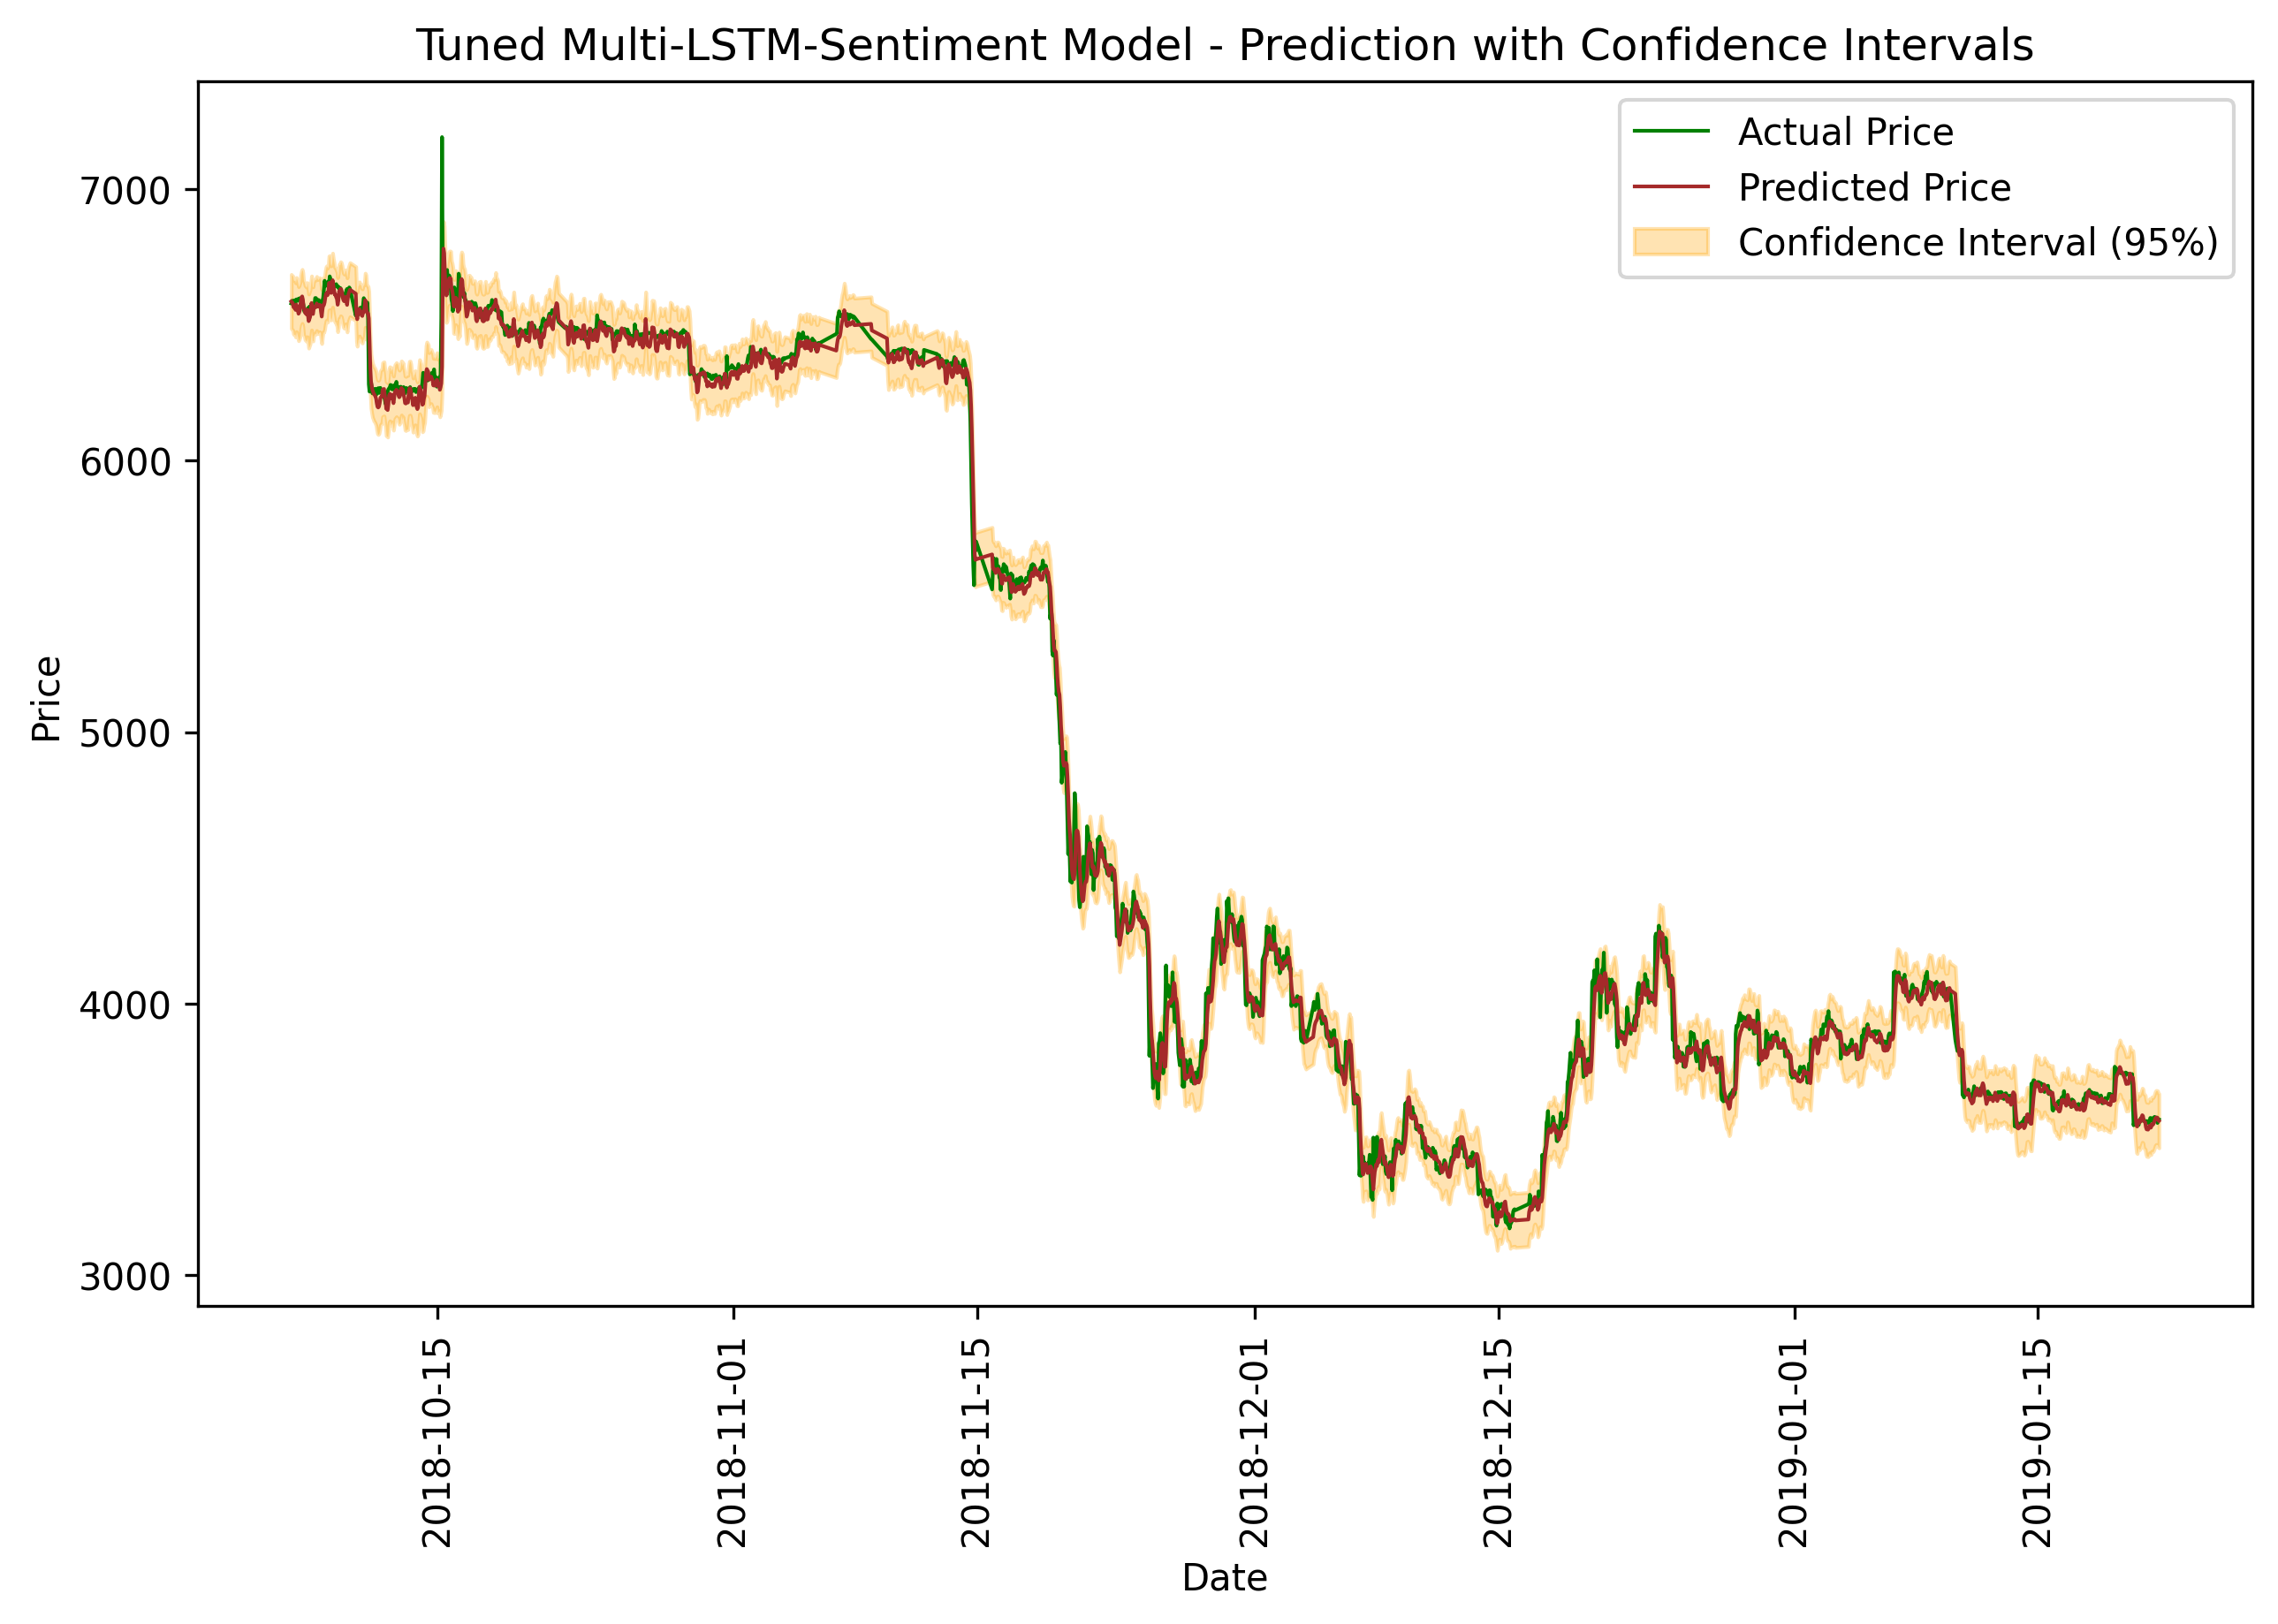

In [ ]:
#test_dates = df['Date'].iloc[-len(y_test):]
#test_dates = df.index[-len(y_test):]

# @title Calculate confidence intervals
residuals = (tune_y_test_inverse - tune_y_pred_inverse).flatten()
std_residuals = np.std(residuals)

# Define the confidence intervals (95% confidence)
confidence_level = 1.96  # For 95% confidence interval (z-score)
upper_bound = (tune_y_pred_inverse + confidence_level * std_residuals).flatten()
lower_bound = (tune_y_pred_inverse - confidence_level * std_residuals).flatten()

# Plot the actual vs predicted values with confidence intervals
test_dates = df['Date'].iloc[-len(y_test):]
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(test_dates, tune_y_test_inverse, label="Actual Price", color='green', lw=1)
plt.plot(test_dates, tune_y_pred_inverse, label="Predicted Price", color='brown', lw=1)
plt.fill_between(
    test_dates,
    lower_bound,
    upper_bound,
    color='orange',
    alpha=0.3,
    label="Confidence Interval (95%)"
)

plt.title('Tuned Multi-LSTM-Sentiment Model - Prediction with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.show()


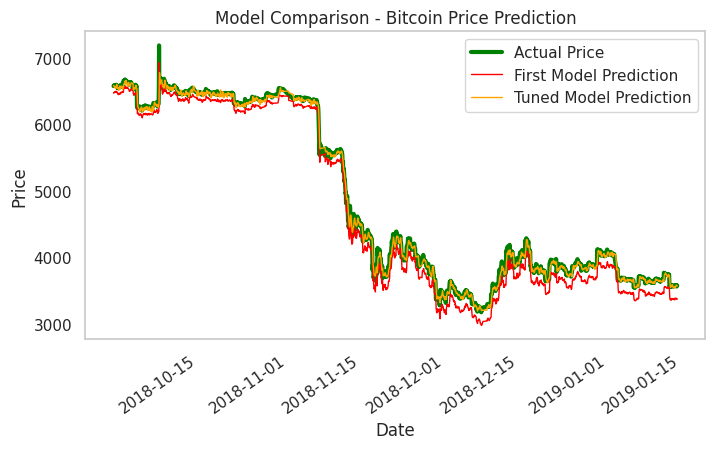

In [ ]:
# @title Plot the Model comparison actual vs predicted values
test_dates = df['Date'].iloc[-len(y_test):]

plt.figure(figsize=(8, 4))
plt.plot(test_dates,tune_y_test_inverse, label="Actual Price", color='green', lw=3)
plt.plot(test_dates,y_pred_inverse, label="First Model Prediction", color='red',lw=1)
plt.plot(test_dates,tune_y_pred_inverse, label="Tuned Model Prediction", color='orange', lw=1)

plt.title('Model Comparison - Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(False)
plt.legend(loc='best')
plt.xticks(rotation=35)
plt.show()